In [1]:
%pylab inline
import pandas as pd
import numpy as np


Populating the interactive namespace from numpy and matplotlib


In [2]:
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index, _concordance_index
from lifelines import CoxPHFitter

In [3]:
# simulating a feature matrix for 100 samples with 50 features
data = np.random.random((100, 5))

# simulating time of observations (days) min 10 days, max 2500 days
observed_time = np.random.randint(10, 2500, (100))

# simulating event (death) 0 did not occur 1 occured
observed_event = np.random.randint(0, 2, (100))

# create a sig feature
data[:,2] = observed_time + np.random.random(size=len(observed_time)) * observed_time

test_data = np.random.random((25, 5))
test_observed_time = np.random.randint(10, 2500, (25))
test_observed_event = np.random.randint(0, 2, (25))

# create a sig feature
test_data[:,2] = test_observed_time + np.random.random(size=len(test_observed_time))* test_observed_time


In [4]:
for feature_id, feature_vect in enumerate(data.T):
        dataframe = pd.DataFrame({
            'feature nb{0}'.format(feature_id): feature_vect,
            'event': observed_event,
            'time': observed_time})

        #building a coxph model to see the significance of each independant feature
        cox_model = CoxPHFitter()

        cox_model.fit(dataframe,
                      duration_col='time',
                      event_col='event')

        pvalue = cox_model.summary.p[0]
        print('pvalue: {0} for feature nb: {1}'.format(
            pvalue, feature_id))

        if pvalue > 0.05:
            #print('feature nb {0} not overall significant!'.format(feature_id))
            continue

        print('feature nb {0} is overall significant!'.format(feature_id))
        # test the robustness: score close / higher to 0.7 is a good sign
        scores = k_fold_cross_validation(cox_model,
                                         dataframe,
                                         duration_col='time',
                                         event_col='event',
                                         k=3)

        print('score (mean) (c-index) for {0}'.format(np.mean(scores)))

        # validate the features on the test set
        test_dataframe = pd.DataFrame({
            'feature nb{0}'.format(feature_id): test_data.T[feature_id],
            'event': test_observed_event,
            'time': test_observed_time})

        inferred_time = cox_model.predict_expectation(test_dataframe)

        validation_c_index = concordance_index(
            test_observed_time,
            inferred_time,
            test_observed_event)

        print('validation c-index: {0}'.format(validation_c_index))


pvalue: 0.32649706438195414 for feature nb: 0
pvalue: 0.7597311507076233 for feature nb: 1
pvalue: 3.8395341671563113e-10 for feature nb: 2
feature nb 2 is overall significant!
score (mean) (c-index) for 0.8873573805232834
validation c-index: 0.9108910891089109
pvalue: 0.4645098417997843 for feature nb: 3
pvalue: 0.5053291501177191 for feature nb: 4


this is the hazard function:
h(t)=h0(t)×exp(b1x1+b2x2+...+bpxp)

that is regressed on... i feel like we could learn that?


In [5]:
df = pd.read_csv('../download/slides.csv')

def tissue_type(x):
    return x.split('-')[4]

df = df.loc[df.slide_file_name.apply(tissue_type) == '01',:].copy()

In [6]:
alive = df[df.days_to_death.isnull()]
dead = df[df.days_to_death.notnull()]

In [15]:
alive.days_to_last_follow_up.hist()

count     82.00000
mean     166.93919
std       20.59417
min       -9.00000
25%      173.00000
50%      115.50000
75%      205.50000
max      417.00000
dtype: float64

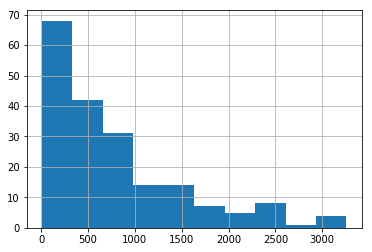

In [16]:
dead.days_to_death.hist()

In [11]:
no_cancer = df.loc[df.percent_tumor_cells == 0,:]
cancer = df.loc[df.percent_tumor_cells > 0,:]

In [12]:
no_cancer.days_to_death.describe()

count      54.000000
mean      991.351852
std       852.992162
min         9.000000
25%       355.000000
50%       777.500000
75%      1525.750000
max      3258.000000
Name: days_to_death, dtype: float64

In [13]:
cancer.days_to_death.describe()

count     140.000000
mean      693.371429
std       692.666709
min         9.000000
25%       209.250000
50%       435.000000
75%       860.750000
max      3258.000000
Name: days_to_death, dtype: float64

In [44]:
end_days = df[['days_to_last_follow_up','days_to_death']].max(axis=1)
life = df.days_to_birth.abs() + end_days

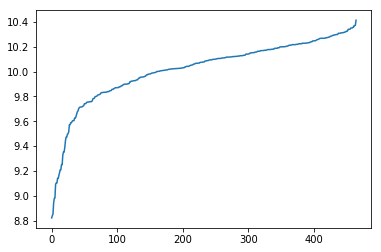

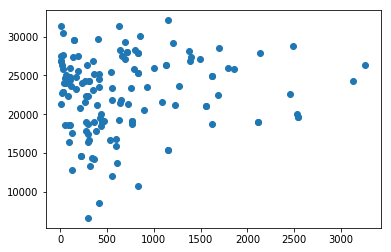

In [28]:
scatter(cancer.days_to_death, cancer.days_to_birth.abs())

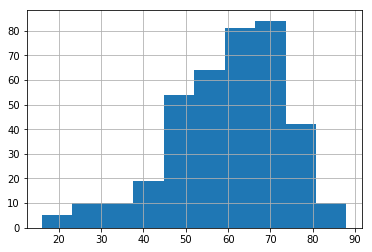

In [31]:
(cancer.days_to_birth.abs() / 365.25).hist()

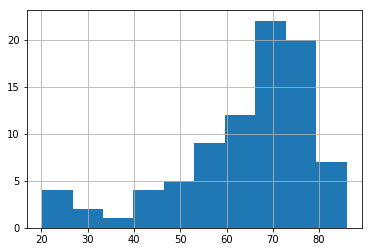

In [33]:
(no_cancer.days_to_birth.abs() / 365.25).hist()